In [44]:
import pandas as pd
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
reviews_df = pd.read_csv(r"data1.csv")
reviews_df

,Title,Positive_Review,Negative_Review,Score
0,"It was okay for a one time stay, but I am not...","Beautiful, historic lobby. I see why it was us...","Large room, but small beds and dirty, outdated...",6.0
1,"Beautiful hotel, but terrible bed in Suite",The hotel lobby and amenities were beautiful! ...,The furniture in the rooms could be refinished...,6.0
2,Good,Architecture,"No tissues, only one nicely folded sticking ou...",7.0
3,Fascinating Interior,We stayed 3 nights during Halloween time. The ...,Everything was good. No complain.,8.8
4,Excellent overall experience.,Loved the hotel overall. Beautiful building an...,The beds were smaller than anticipated and the...,8.0
...,...,...,...,...
39725,Pleasant,Location,The heater is too loud. The The bathroom doesn...,6.0
39726,Dixie Hollywood,Excellent rooms and nice pool although very cold,Nothing to say here,9.6
39727,"Convenient to the metro, but very basic","Great location on the metro, giving fast acces...",No drinking water available on site (i was dir...,5.8
39728,Basic motel in Hollywood,The location is certainly not in a nice part o...,"There are no lights in the room, just really b...",5.4


In [48]:
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
reviews_df

,Title,Positive_Review,Negative_Review,Score,review
0,"It was okay for a one time stay, but I am not...","Beautiful, historic lobby. I see why it was us...","Large room, but small beds and dirty, outdated...",6.0,"Large room, but small beds and dirty, outdated..."
1,"Beautiful hotel, but terrible bed in Suite",The hotel lobby and amenities were beautiful! ...,The furniture in the rooms could be refinished...,6.0,The furniture in the rooms could be refinished...
2,Good,Architecture,"No tissues, only one nicely folded sticking ou...",7.0,"No tissues, only one nicely folded sticking ou..."
3,Fascinating Interior,We stayed 3 nights during Halloween time. The ...,Everything was good. No complain.,8.8,Everything was good. No complain.We stayed 3 n...
4,Excellent overall experience.,Loved the hotel overall. Beautiful building an...,The beds were smaller than anticipated and the...,8.0,The beds were smaller than anticipated and the...
...,...,...,...,...,...
39725,Pleasant,Location,The heater is too loud. The The bathroom doesn...,6.0,The heater is too loud. The The bathroom doesn...
39726,Dixie Hollywood,Excellent rooms and nice pool although very cold,Nothing to say here,9.6,Nothing to say hereExcellent rooms and nice po...
39727,"Convenient to the metro, but very basic","Great location on the metro, giving fast acces...",No drinking water available on site (i was dir...,5.8,No drinking water available on site (i was dir...
39728,Basic motel in Hollywood,The location is certainly not in a nice part o...,"There are no lights in the room, just really b...",5.4,"There are no lights in the room, just really b..."


In [49]:
# create the label
reviews_df["is_bad_review"] = reviews_df["Score"].apply(lambda x: 1 if x < 7 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df

,review,is_bad_review
0,"Large room, but small beds and dirty, outdated...",1
1,The furniture in the rooms could be refinished...,1
2,"No tissues, only one nicely folded sticking ou...",0
3,Everything was good. No complain.We stayed 3 n...,0
4,The beds were smaller than anticipated and the...,0
...,...,...
39725,The heater is too loud. The The bathroom doesn...,1
39726,Nothing to say hereExcellent rooms and nice po...,0
39727,No drinking water available on site (i was dir...,1
39728,"There are no lights in the room, just really b...",1


In [50]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))
reviews_df

,review,is_bad_review,review_clean
0,"Large room, but small beds and dirty, outdated...",1,large room small bed dirty outdated room room ...
1,The furniture in the rooms could be refinished...,1,furniture room could refinish get want use fur...
2,"No tissues, only one nicely folded sticking ou...",0,tissue one nicely fold stick box one wash clot...
3,Everything was good. No complain.We stayed 3 n...,0,everything good complain.we stay night hallowe...
4,The beds were smaller than anticipated and the...,0,bed small anticipated stair option convenient ...
...,...,...,...
39725,The heater is too loud. The The bathroom doesn...,1,heater loud bathroom doesn’t look clean furnit...
39726,Nothing to say hereExcellent rooms and nice po...,0,nothing say hereexcellent room nice pool altho...
39727,No drinking water available on site (i was dir...,1,drinking water available site direct near supe...
39728,"There are no lights in the room, just really b...",1,light room really bright one ceiling feel like...


In [51]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chloezhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chloezhang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [53]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chloezhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chloezhang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [55]:
# add sentiment anaylsis columns
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)
reviews_df

,review,is_bad_review,review_clean,neg,neu,pos,compound
0,"Large room, but small beds and dirty, outdated...",1,large room small bed dirty outdated room room ...,0.215,0.753,0.032,-0.8214
1,The furniture in the rooms could be refinished...,1,furniture room could refinish get want use fur...,0.035,0.777,0.188,0.9898
2,"No tissues, only one nicely folded sticking ou...",0,tissue one nicely fold stick box one wash clot...,0.060,0.852,0.088,0.2481
3,Everything was good. No complain.We stayed 3 n...,0,everything good complain.we stay night hallowe...,0.036,0.866,0.098,0.5829
4,The beds were smaller than anticipated and the...,0,bed small anticipated stair option convenient ...,0.147,0.746,0.107,-0.0119
...,...,...,...,...,...,...,...
39725,The heater is too loud. The The bathroom doesn...,1,heater loud bathroom doesn’t look clean furnit...,0.000,0.870,0.130,0.4019
39726,Nothing to say hereExcellent rooms and nice po...,0,nothing say hereexcellent room nice pool altho...,0.000,0.781,0.219,0.4215
39727,No drinking water available on site (i was dir...,1,drinking water available site direct near supe...,0.145,0.751,0.104,-0.2960
39728,"There are no lights in the room, just really b...",1,light room really bright one ceiling feel like...,0.084,0.806,0.110,0.4936


In [56]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))
reviews_df

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words
0,"Large room, but small beds and dirty, outdated...",1,large room small bed dirty outdated room room ...,0.215,0.753,0.032,-0.8214,189,31
1,The furniture in the rooms could be refinished...,1,furniture room could refinish get want use fur...,0.035,0.777,0.188,0.9898,1169,213
2,"No tissues, only one nicely folded sticking ou...",0,tissue one nicely fold stick box one wash clot...,0.060,0.852,0.088,0.2481,178,34
3,Everything was good. No complain.We stayed 3 n...,0,everything good complain.we stay night hallowe...,0.036,0.866,0.098,0.5829,344,56
4,The beds were smaller than anticipated and the...,0,bed small anticipated stair option convenient ...,0.147,0.746,0.107,-0.0119,373,67
...,...,...,...,...,...,...,...,...,...
39725,The heater is too loud. The The bathroom doesn...,1,heater loud bathroom doesn’t look clean furnit...,0.000,0.870,0.130,0.4019,119,19
39726,Nothing to say hereExcellent rooms and nice po...,0,nothing say hereexcellent room nice pool altho...,0.000,0.781,0.219,0.4215,67,11
39727,No drinking water available on site (i was dir...,1,drinking water available site direct near supe...,0.145,0.751,0.104,-0.2960,283,50
39728,"There are no lights in the room, just really b...",1,light room really bright one ceiling feel like...,0.084,0.806,0.110,0.4936,412,82


In [57]:
pip install gensim --user --no-warn-script-location

Note: you may need to restart the kernel to use updated packages.


In [58]:
# create doc2vec vector columns
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)
reviews_df

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,"Large room, but small beds and dirty, outdated...",1,large room small bed dirty outdated room room ...,0.215,0.753,0.032,-0.8214,189,31,0.089347,0.204812,-0.047595,-0.174174,-0.090105
1,The furniture in the rooms could be refinished...,1,furniture room could refinish get want use fur...,0.035,0.777,0.188,0.9898,1169,213,0.276819,0.819609,0.079328,-0.356510,0.381917
2,"No tissues, only one nicely folded sticking ou...",0,tissue one nicely fold stick box one wash clot...,0.060,0.852,0.088,0.2481,178,34,-0.082159,0.265264,0.055494,-0.084371,0.213500
3,Everything was good. No complain.We stayed 3 n...,0,everything good complain.we stay night hallowe...,0.036,0.866,0.098,0.5829,344,56,0.273906,0.330818,0.344234,-0.095958,-0.359294
4,The beds were smaller than anticipated and the...,0,bed small anticipated stair option convenient ...,0.147,0.746,0.107,-0.0119,373,67,0.119167,-0.066648,0.122943,-0.370613,-0.097614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39725,The heater is too loud. The The bathroom doesn...,1,heater loud bathroom doesn’t look clean furnit...,0.000,0.870,0.130,0.4019,119,19,0.025393,0.269331,0.027347,-0.037258,-0.055374
39726,Nothing to say hereExcellent rooms and nice po...,0,nothing say hereexcellent room nice pool altho...,0.000,0.781,0.219,0.4215,67,11,0.148656,0.066146,0.078989,-0.131450,-0.005627
39727,No drinking water available on site (i was dir...,1,drinking water available site direct near supe...,0.145,0.751,0.104,-0.2960,283,50,0.260078,-0.146723,-0.281415,-0.321421,-0.271398
39728,"There are no lights in the room, just really b...",1,light room really bright one ceiling feel like...,0.084,0.806,0.110,0.4936,412,82,0.089326,0.264440,0.173049,-0.121366,-0.096700


In [59]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [60]:
reviews_df.head()

,review,is_bad_review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,...,word_yogurt,word_york,word_you,word_young,word_your,word_youre,word_youtube,word_yummy,word_zero,word_zone
0,"Large room, but small beds and dirty, outdated...",1,large room small bed dirty outdated room room ...,0.215,0.753,0.032,-0.8214,189,31,0.089347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The furniture in the rooms could be refinished...,1,furniture room could refinish get want use fur...,0.035,0.777,0.188,0.9898,1169,213,0.276819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"No tissues, only one nicely folded sticking ou...",0,tissue one nicely fold stick box one wash clot...,0.060,0.852,0.088,0.2481,178,34,-0.082159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Everything was good. No complain.We stayed 3 n...,0,everything good complain.we stay night hallowe...,0.036,0.866,0.098,0.5829,344,56,0.273906,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The beds were smaller than anticipated and the...,0,bed small anticipated stair option convenient ...,0.147,0.746,0.107,-0.0119,373,67,0.119167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
reviews_df.shape

(39730, 3830)

In [63]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.698439
1    0.301561
Name: is_bad_review, dtype: float64

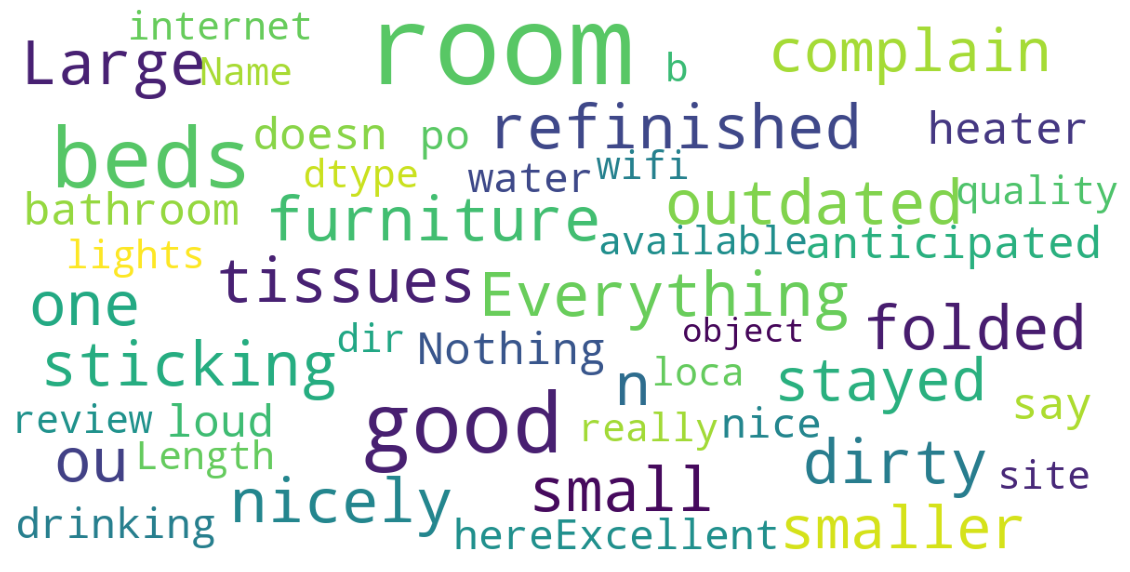

In [64]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

In [65]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
32417,Clean comfortable great bathroom,0.910
25195,Clean and super comfortable,0.908
37709,Friendly staff.. awesome value,0.907
5595,"Beautiful, Clean and Efficient!",0.906
37073,"Clean , quite , neat , peaceful",0.905
13726,Nice clean and friendly.,0.897
32362,"Great location, parking, super clean, comfort...",0.875
25720,Staff super nice 😊,0.870
30002,"CLEAN, COMFORTABLE, and GREAT LOCATION!!!👍👍👍",0.868
15811,"Clean, super helpful and courteous staff",0.864


In [66]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
30130,very bad bad hotelvery bad hotel,0.791
27950,"Unfriendly staff, \rWorst breakfast",0.767
22692,Bad service \nBad parking \nUncomfortable be...,0.758
28883,"Bad zone, dirty, no secure, poor conditions",0.727
7095,Unkind staff. Never smiling,0.718
30908,"No Air-conditioning, no internet, bad neighbo...",0.716
21657,- Wifi sucks\r - Service sucks,0.714
31784,I have no complaints .Everything.,0.710
866,EVERYTHING WAS HORRIBLE!Horrible Horrible Horr...,0.709
22098,Horrible staffStaff has bad attitudes,0.700


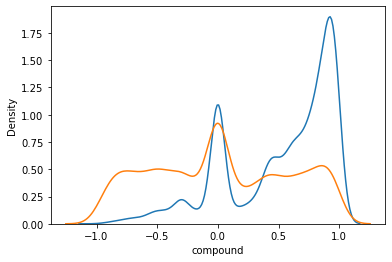

In [67]:
# plot sentiment distribution for positive and negative reviews
for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [68]:
def train_predict_evaluate_model(classifier,train_features,train_labels,test_features,test_labels):
    classifier.fit(train_features, train_labels)
    predictions=classifier.predict(test_features)
    return predictions

In [69]:
# Using tf-idf only

In [76]:
label = "is_bad_review"
ignore_cols1 = reviews_df.iloc[:,0:14]
features1 = [c for c in reviews_df.columns if c not in ignore_cols1]

In [77]:
# split the data into train and test
X_train1, X_test1, y_train1, y_test1 = train_test_split(reviews_df[features1], reviews_df[label], test_size = 0.20, random_state = 42)

In [72]:
#Model1 SGDClassifier

In [78]:
svm1=SGDClassifier(loss='log',max_iter=1000)
svm1_pre=train_predict_evaluate_model(classifier=svm1,train_features=X_train1,train_labels=y_train1,test_features=X_test1,test_labels=y_test1)

In [79]:
accuracy_score(y_test1, svm1_pre)

0.8138686131386861

In [80]:
pd.DataFrame(confusion_matrix(y_test1, svm1_pre))

,0,1
0,5240,334
1,1145,1227


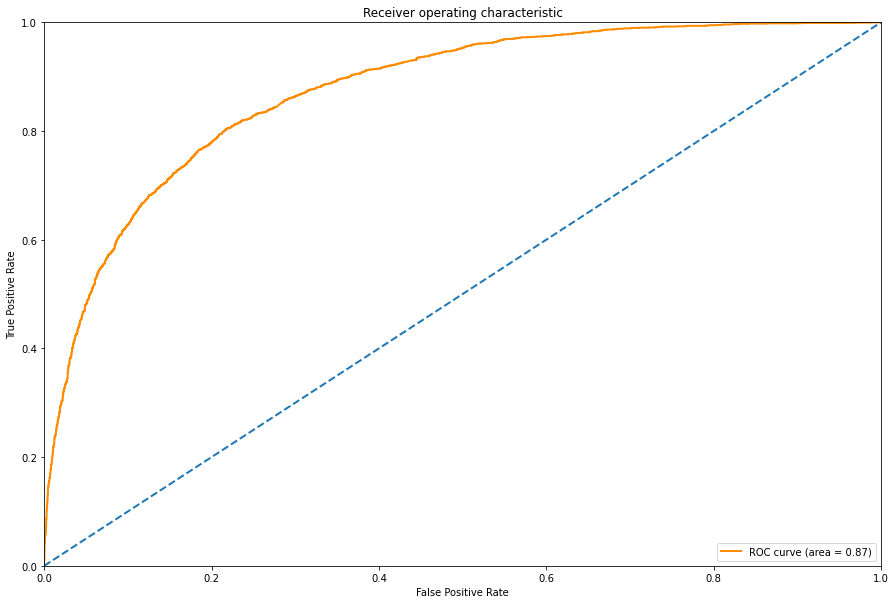

In [81]:
# ROC curve
y_pred1 = [x[1] for x in svm1.predict_proba(X_test1)]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

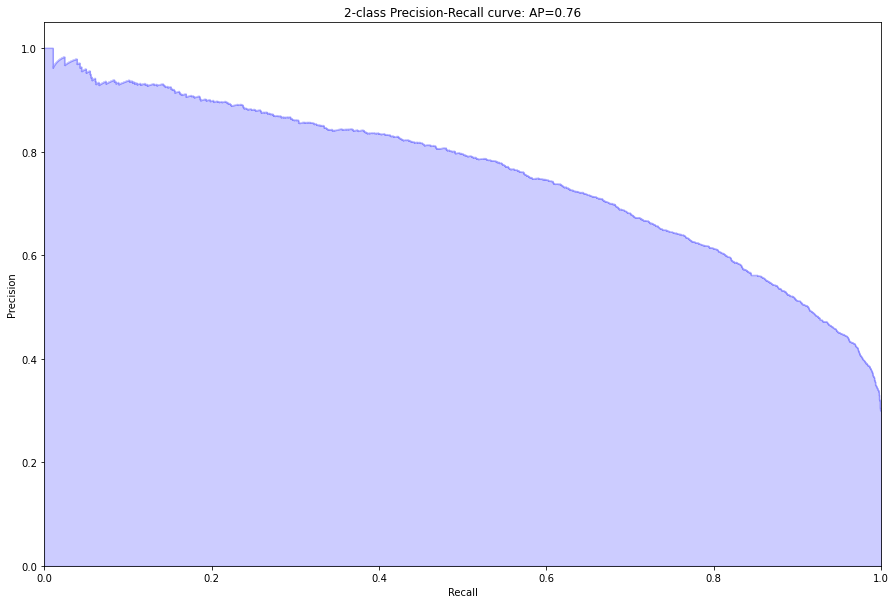

In [82]:
# PR curve
average_precision = average_precision_score(y_test1, y_pred1)

precision, recall, _ = precision_recall_curve(y_test1, y_pred1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
#Model2 Decision Tree Classifier

In [83]:
clf1 = tree.DecisionTreeClassifier()
clf1.fit(X_train1, y_train1)

DecisionTreeClassifier()

In [84]:
clf1_pre=train_predict_evaluate_model(classifier=clf1,train_features=X_train1,train_labels=y_train1,test_features=X_test1,test_labels=y_test1)

In [85]:
accuracy_score(y_test1, clf1_pre)

0.7379813742763655

In [86]:
pd.DataFrame(confusion_matrix(y_test1, clf1_pre))

,0,1
0,4591,983
1,1099,1273


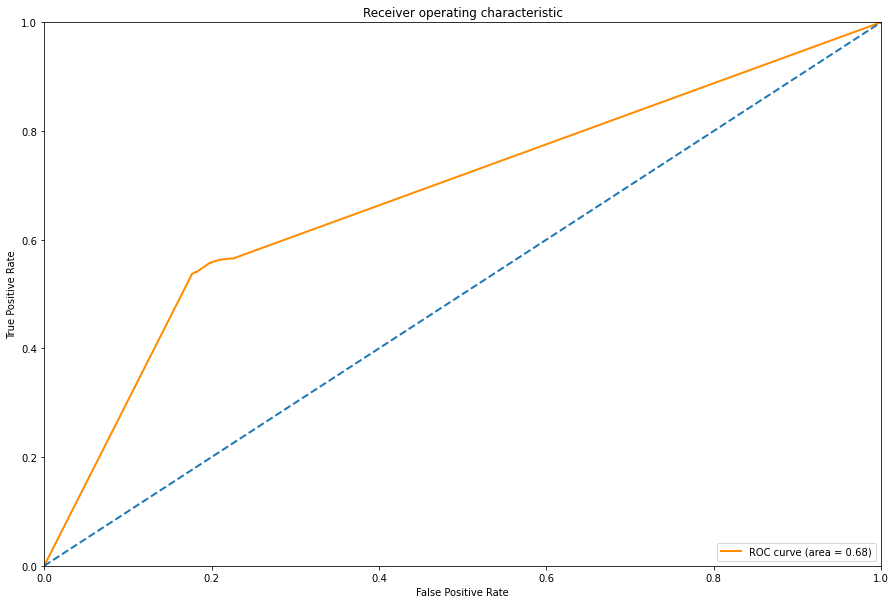

In [87]:
# ROC curve
y_pred1 = [x[1] for x in clf1.predict_proba(X_test1)]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.45')

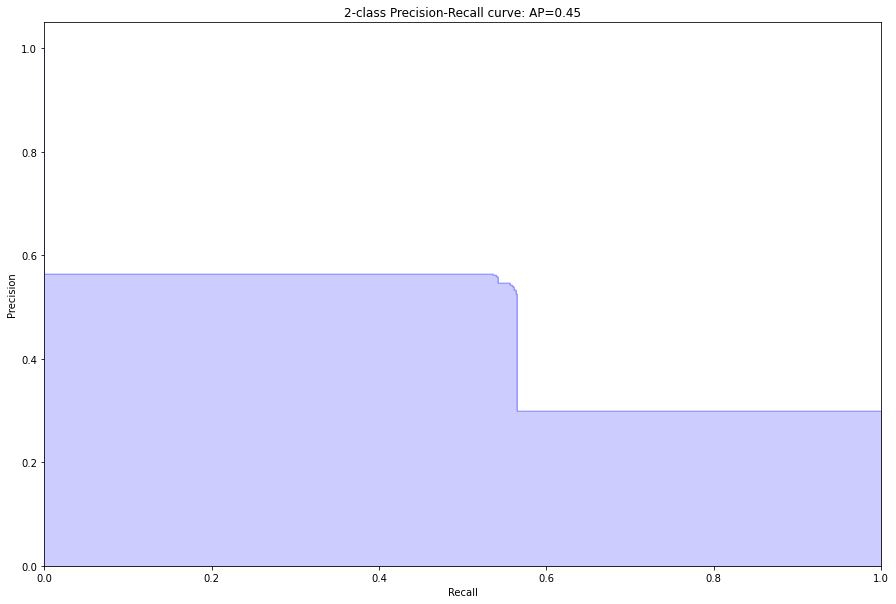

In [88]:
# PR curve
average_precision = average_precision_score(y_test1, y_pred1)

precision, recall, _ = precision_recall_curve(y_test1, y_pred1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [89]:
#Model3 Logistic Regression Classifier

In [91]:
logreg1 = LogisticRegression(C=1,penalty='l2')
log1_pre=train_predict_evaluate_model(classifier=logreg1,train_features=X_train1,train_labels=y_train1,test_features=X_test1,test_labels=y_test1)

In [92]:
accuracy_score(y_test1, log1_pre)

0.818147495595268

In [93]:
pd.DataFrame(confusion_matrix(y_test1, log1_pre))

,0,1
0,5109,465
1,980,1392


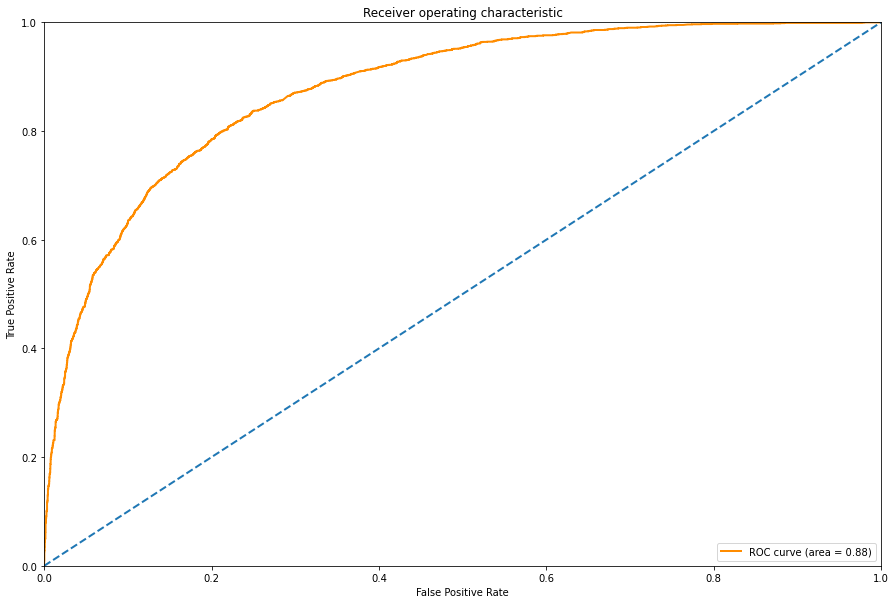

In [94]:
# ROC curve
y_pred1 = [x[1] for x in logreg1 .predict_proba(X_test1)]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.76')

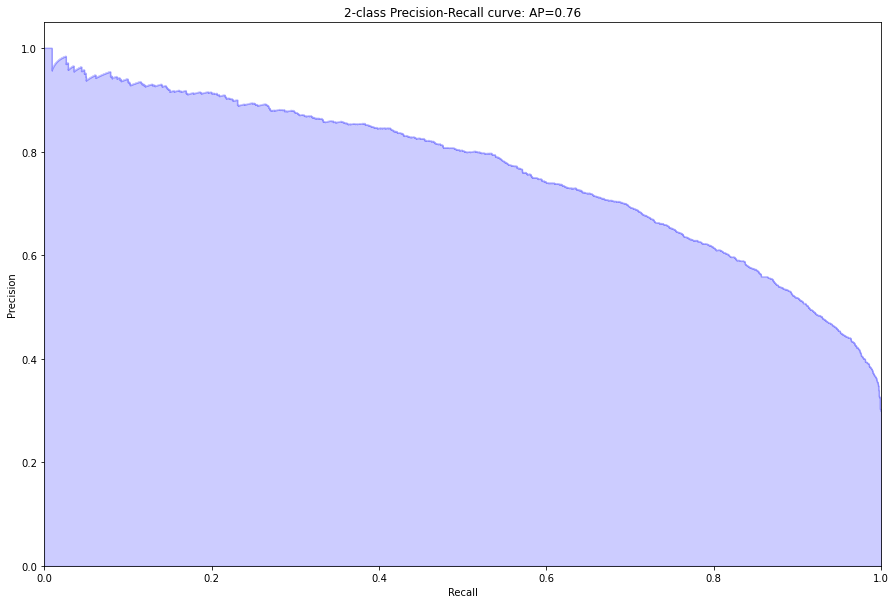

In [95]:
# PR curve
average_precision = average_precision_score(y_test1, y_pred1)

precision, recall, _ = precision_recall_curve(y_test1, y_pred1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
#Model4 KNN Classifier

In [96]:
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(X_train1, y_train1)

KNeighborsClassifier()

In [97]:
knn1_pre=train_predict_evaluate_model(classifier=knn1,train_features=X_train1,train_labels=y_train1,test_features=X_test1,test_labels=y_test1)

In [98]:
accuracy_score(y_test1, knn1_pre)

0.6810974075006292

In [99]:
pd.DataFrame(confusion_matrix(y_test1, knn1_pre))

,0,1
0,4935,639
1,1895,477


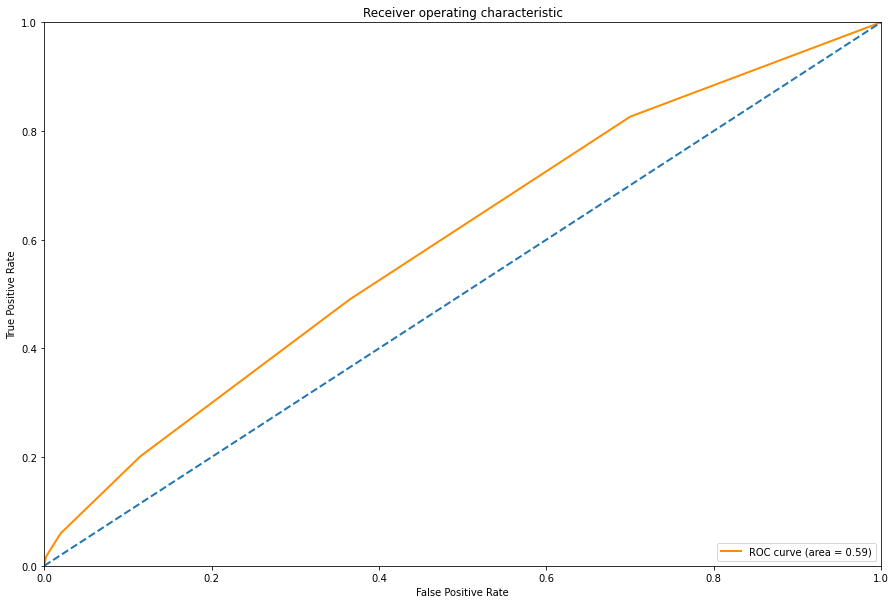

In [100]:
# ROC curve
y_pred1 = [x[1] for x in knn1.predict_proba(X_test1)]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.37')

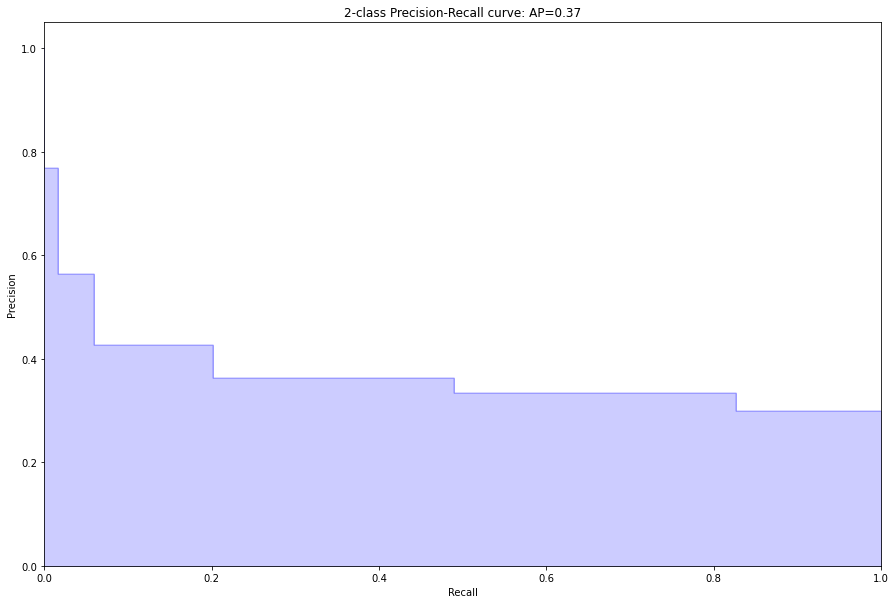

In [101]:
# PR curve
average_precision = average_precision_score(y_test1, y_pred1)

precision, recall, _ = precision_recall_curve(y_test1, y_pred1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
#Model5 Random Forest

In [102]:
rf1 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf1.fit(X_train1, y_train1)

RandomForestClassifier(random_state=42)

In [103]:
rf1_pre=train_predict_evaluate_model(classifier=rf1,train_features=X_train1,train_labels=y_train1,test_features=X_test1,test_labels=y_test1)

In [104]:
accuracy_score(y_test1, rf1_pre)

0.7978857286685125

In [105]:
pd.DataFrame(confusion_matrix(y_test1, rf1_pre))

,0,1
0,5192,382
1,1224,1148


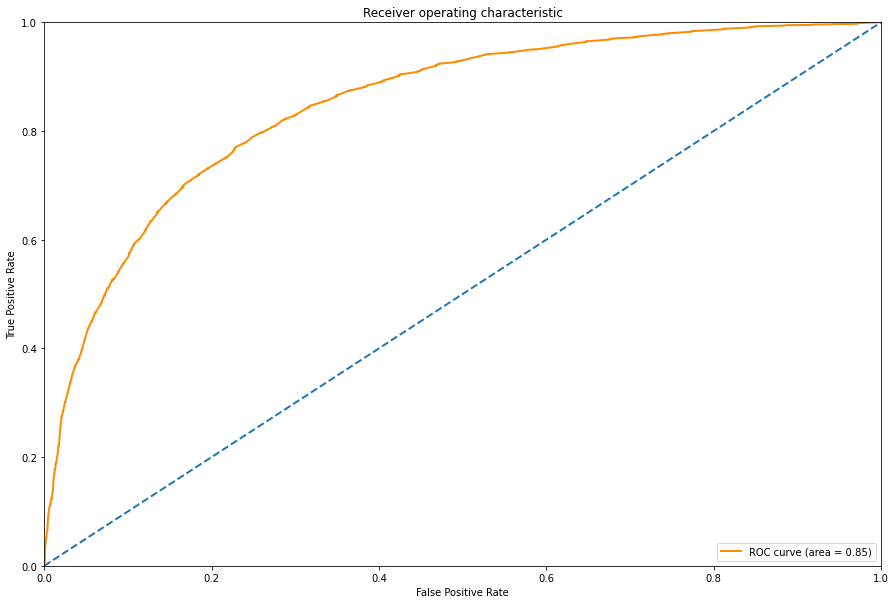

In [106]:
# ROC curve
y_pred1 = [x[1] for x in rf1.predict_proba(X_test1)]
fpr, tpr, thresholds = roc_curve(y_test1, y_pred1, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.71')

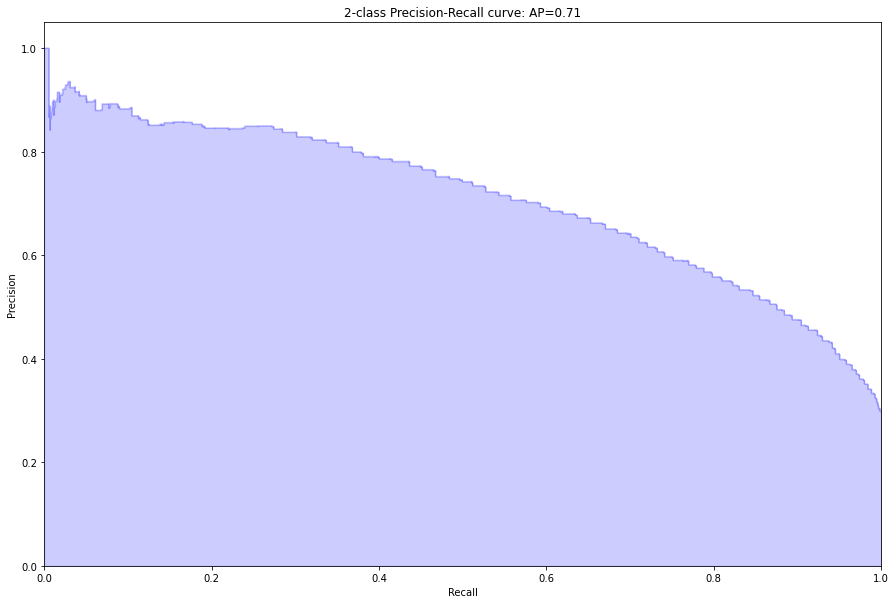

In [107]:
# PR curve
average_precision = average_precision_score(y_test1, y_pred1)

precision, recall, _ = precision_recall_curve(y_test1, y_pred1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [108]:
# Using Doc2Vec only

In [157]:
# feature selection
label = "is_bad_review"
features2 = [c for c in reviews_df.iloc[:,9:14]]

In [159]:
# split the data into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(reviews_df[features2], reviews_df[label], test_size = 0.20, random_state = 42)

In [160]:
#Model1 SGDClassifier

In [161]:
svm2=SGDClassifier(loss='log',max_iter=1000)
svm2_pre=train_predict_evaluate_model(classifier=svm2,train_features=X_train2,train_labels=y_train2,test_features=X_test2,test_labels=y_test2)

In [162]:
accuracy_score(y_test2, svm2_pre)

0.7394915680845708

In [163]:
pd.DataFrame(confusion_matrix(y_test2, svm2_pre))

,0,1
0,5204,370
1,1700,672


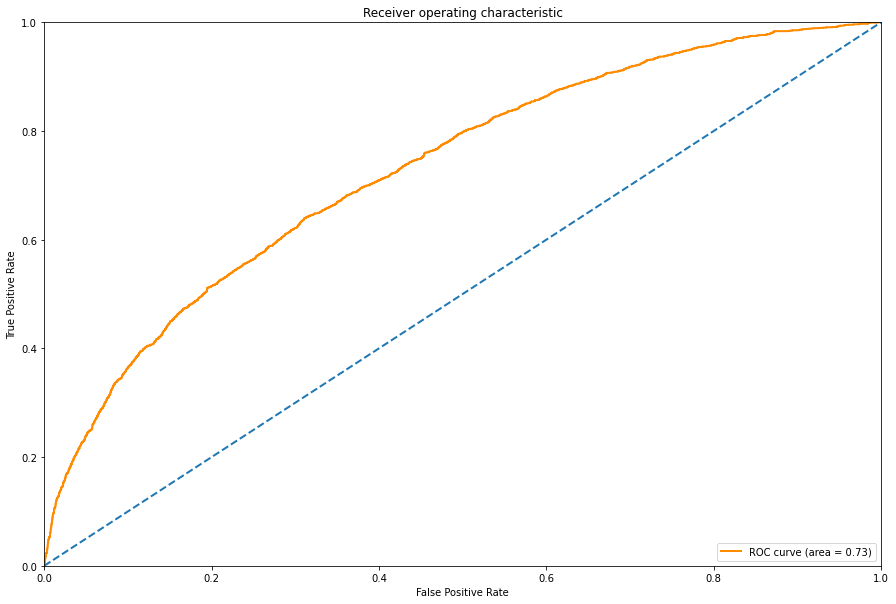

In [164]:
# ROC curve
y_pred2 = [x[1] for x in svm2.predict_proba(X_test2)]
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.55')

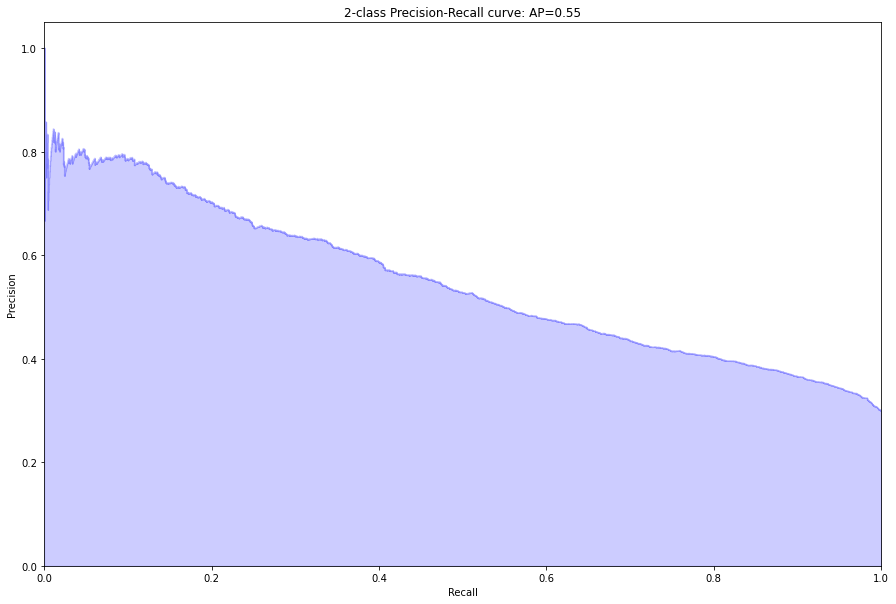

In [165]:
# PR curve
average_precision = average_precision_score(y_test2, y_pred2)

precision, recall, _ = precision_recall_curve(y_test2, y_pred2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
#Model2 Decision Tree Classifier

In [166]:
clf2 = tree.DecisionTreeClassifier()
clf2.fit(X_train2, y_train2)

DecisionTreeClassifier()

In [167]:
clf2_pre=train_predict_evaluate_model(classifier=clf2,train_features=X_train2,train_labels=y_train2,test_features=X_test2,test_labels=y_test2)

In [168]:
accuracy_score(y_test2, clf2_pre)

0.640448024163101

In [169]:
pd.DataFrame(confusion_matrix(y_test2, clf2_pre))

,0,1
0,4096,1478
1,1379,993


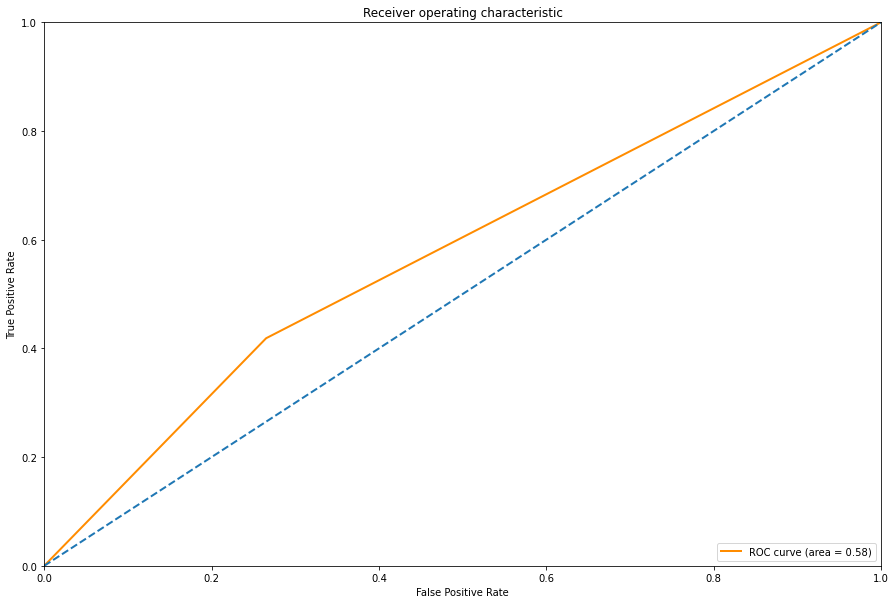

In [170]:
# ROC curve
y_pred2 = [x[1] for x in clf2.predict_proba(X_test2)]
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.34')

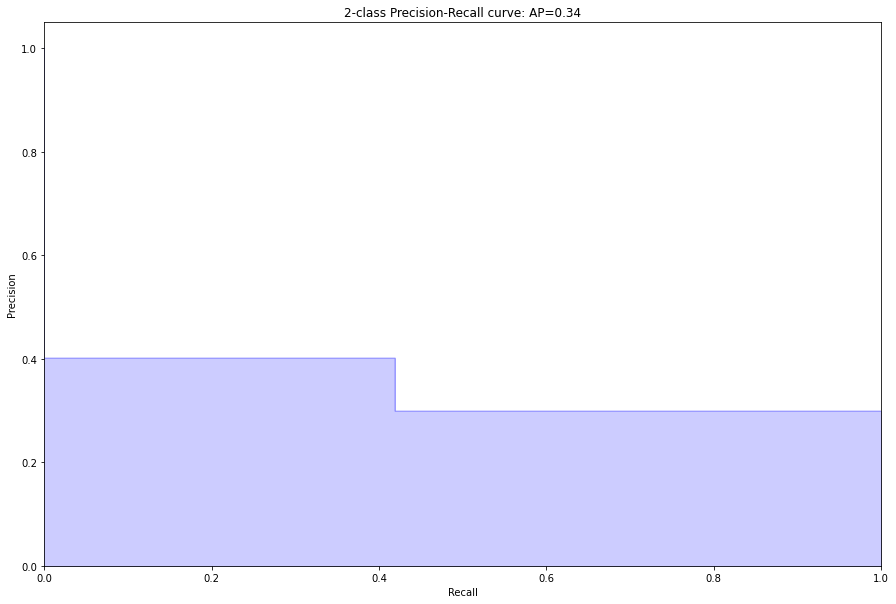

In [171]:
# PR curve
average_precision = average_precision_score(y_test2, y_pred2)

precision, recall, _ = precision_recall_curve(y_test2, y_pred2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [89]:
#Model3 Logistic Regression Classifier

In [172]:
logreg2 = LogisticRegression(C=1,penalty='l2')
log2_pre=train_predict_evaluate_model(classifier=logreg2,train_features=X_train2,train_labels=y_train2,test_features=X_test2,test_labels=y_test2)

In [173]:
accuracy_score(y_test2, log2_pre)

0.7381072237603826

In [174]:
pd.DataFrame(confusion_matrix(y_test2, log2_pre))

,0,1
0,5277,297
1,1784,588


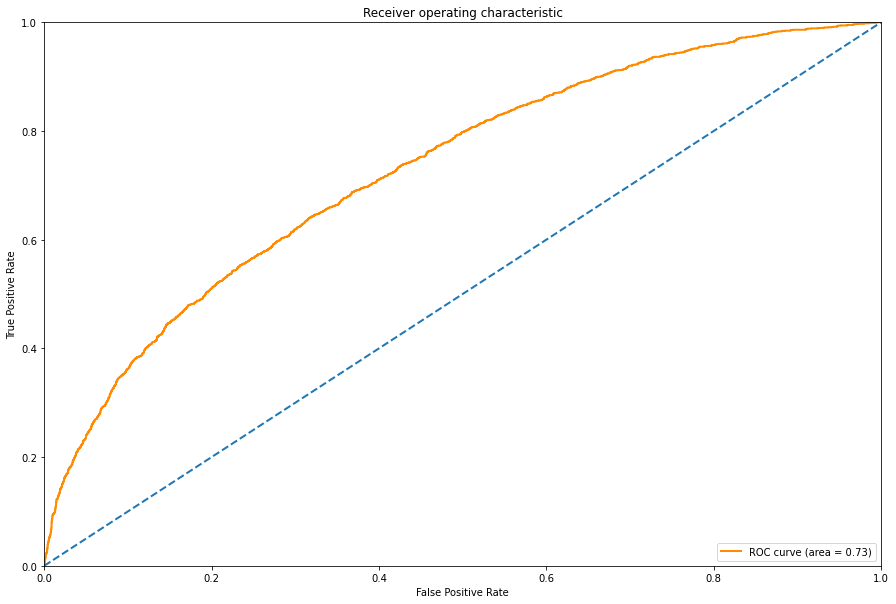

In [175]:
# ROC curve
y_pred2 = [x[1] for x in logreg2.predict_proba(X_test2)]
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.55')

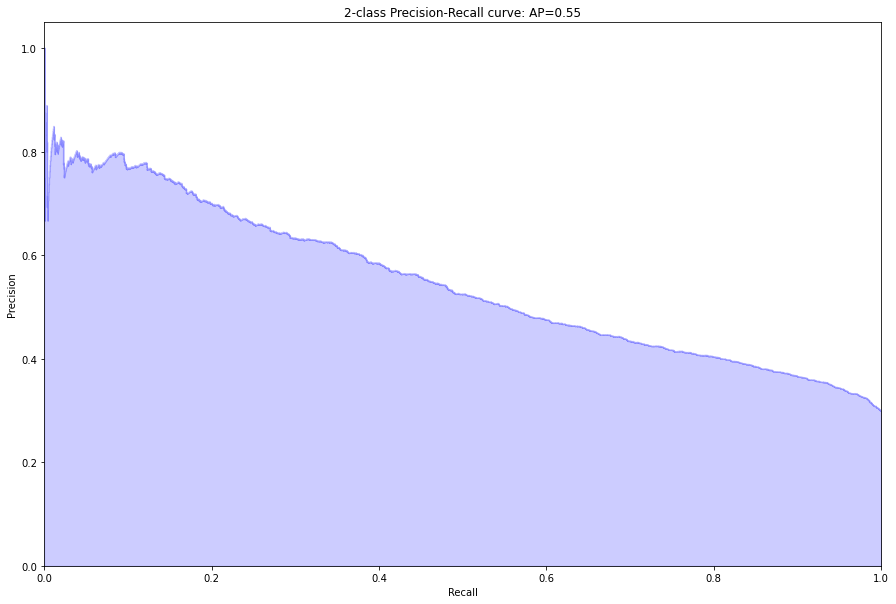

In [176]:
# PR curve
average_precision = average_precision_score(y_test2, y_pred2)

precision, recall, _ = precision_recall_curve(y_test2, y_pred2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
#Model4 KNN Classifier

In [178]:
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X_train2, y_train2)

KNeighborsClassifier()

In [179]:
knn2_pre=train_predict_evaluate_model(classifier=knn2,train_features=X_train2,train_labels=y_train2,test_features=X_test2,test_labels=y_test2)

In [180]:
accuracy_score(y_test2, knn2_pre)

0.7028693682355902

In [181]:
pd.DataFrame(confusion_matrix(y_test2, knn2_pre))

,0,1
0,4749,825
1,1536,836


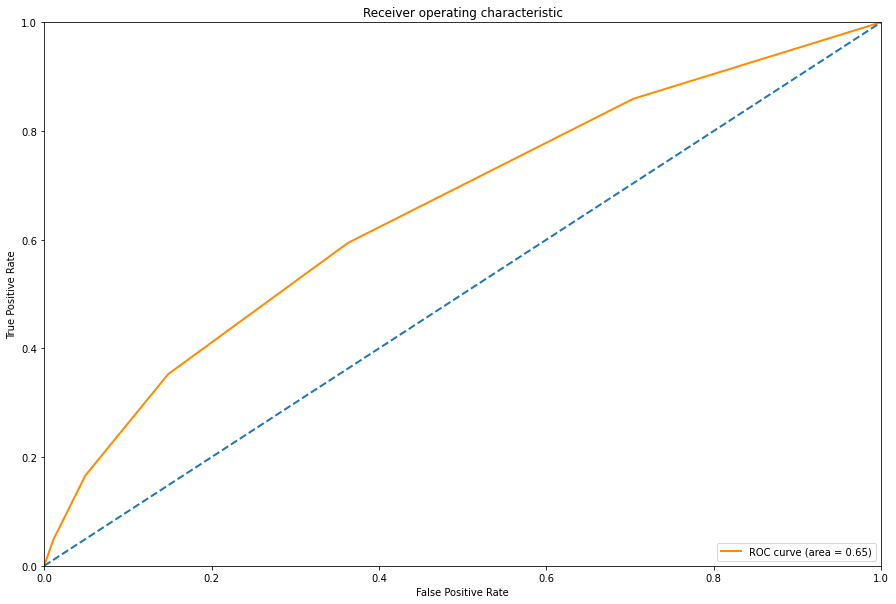

In [182]:
# ROC curve
y_pred2 = [x[1] for x in knn2.predict_proba(X_test2)]
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.43')

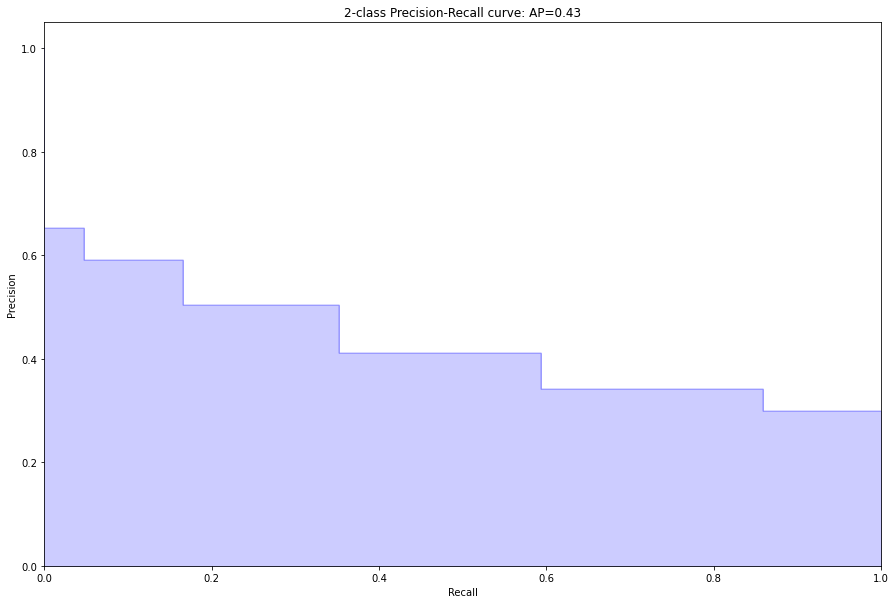

In [183]:
# PR curve
average_precision = average_precision_score(y_test2, y_pred2)

precision, recall, _ = precision_recall_curve(y_test2, y_pred2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
#Model5 Random Forest

In [185]:
rf2 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf2.fit(X_train2, y_train2)

RandomForestClassifier(random_state=42)

In [186]:
rf2_pre=train_predict_evaluate_model(classifier=rf2,train_features=X_train2,train_labels=y_train2,test_features=X_test2,test_labels=y_test2)

In [188]:
accuracy_score(y_test2, rf2_pre)

0.7313113516234584

In [189]:
pd.DataFrame(confusion_matrix(y_test2, rf2_pre))

,0,1
0,5040,534
1,1601,771


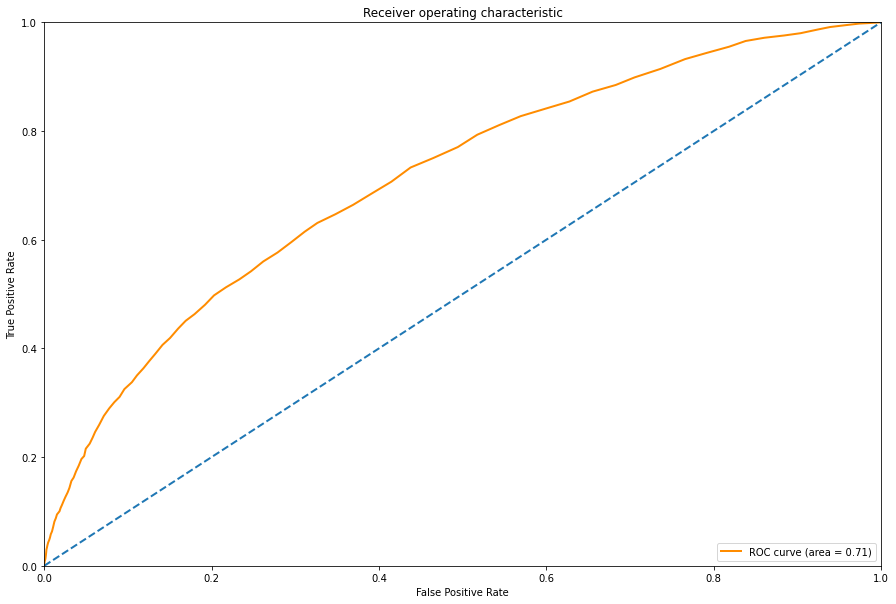

In [190]:
# ROC curve
y_pred2 = [x[1] for x in rf2.predict_proba(X_test2)]
fpr, tpr, thresholds = roc_curve(y_test2, y_pred2, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.52')

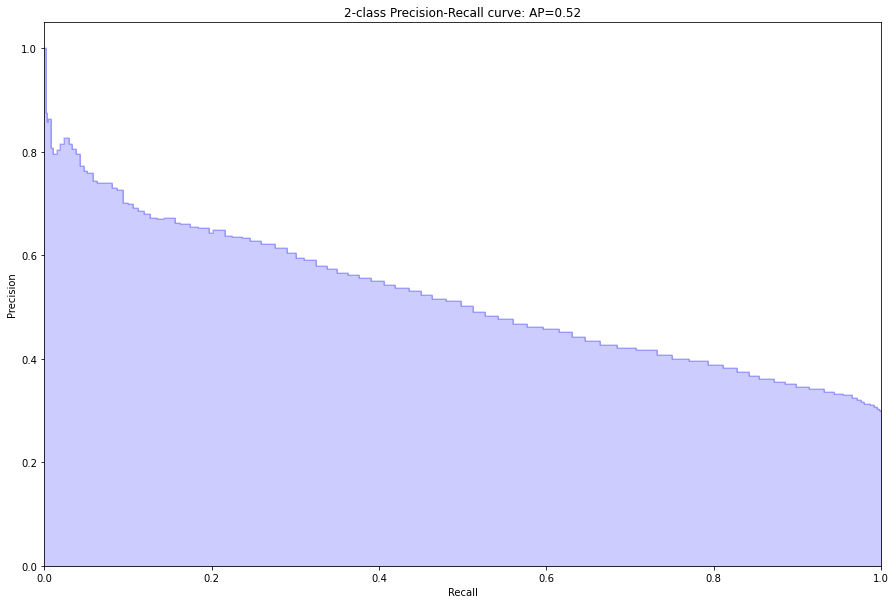

In [191]:
# PR curve
average_precision = average_precision_score(y_test2, y_pred2)

precision, recall, _ = precision_recall_curve(y_test2, y_pred2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
# Using tf-idf with other features

In [193]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean","doc2vec_vector_0","doc2vec_vector_1","doc2vec_vector_2","doc2vec_vector_3","doc2vec_vector_4"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

In [194]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [195]:
#Model1 SGDClassifier

In [196]:
svm=SGDClassifier(loss='log',max_iter=1000)
svm_pre=train_predict_evaluate_model(classifier=svm,train_features=X_train,train_labels=y_train,test_features=X_test,test_labels=y_test)

In [197]:
accuracy_score(y_test, svm_pre)

0.5777749811225774

In [198]:
pd.DataFrame(confusion_matrix(y_test, svm_pre))

,0,1
0,2535,3039
1,316,2056


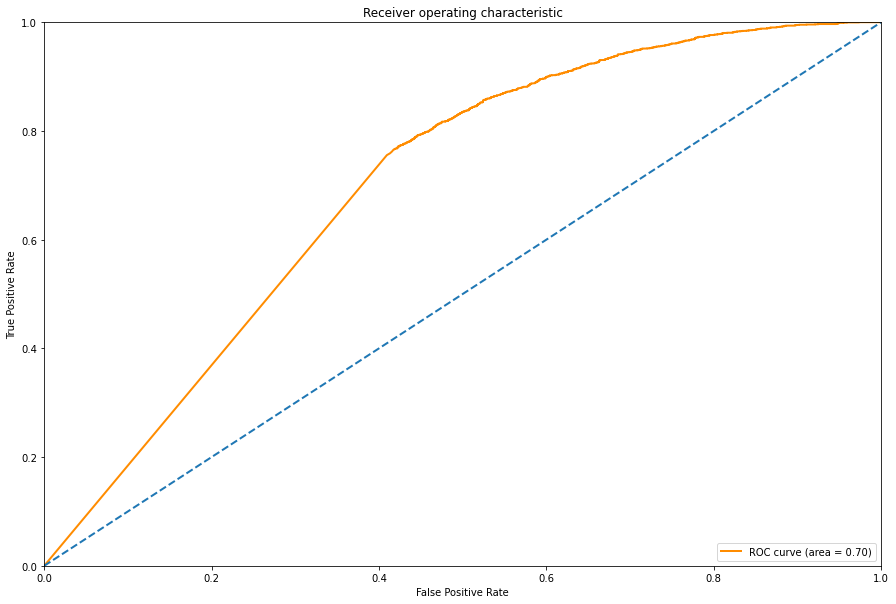

In [201]:
# ROC curve
y_pred = [x[1] for x in svm.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.43')

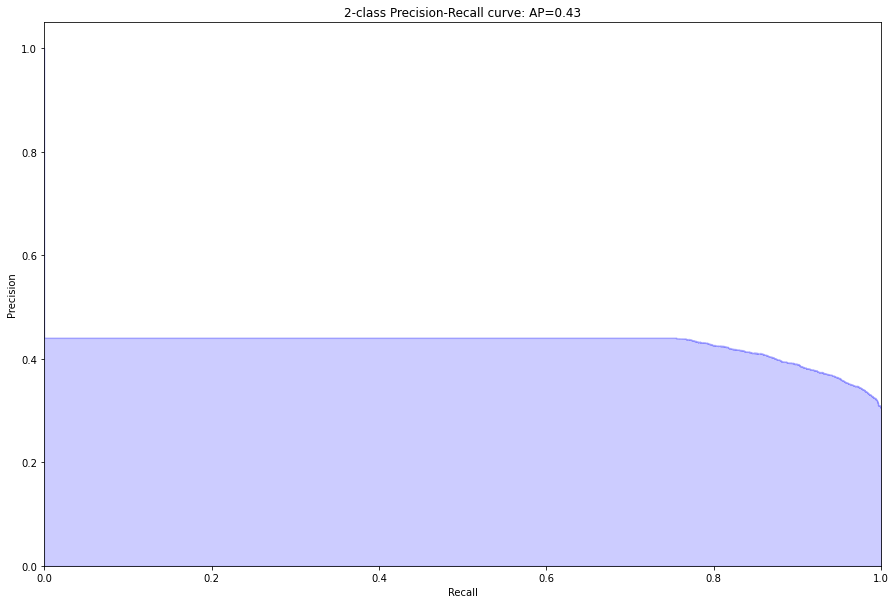

In [202]:
# PR curve
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [203]:
#Model2 Decision Tree Classifier

In [204]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [205]:
clf_pre=train_predict_evaluate_model(classifier=clf,train_features=X_train,train_labels=y_train,test_features=X_test,test_labels=y_test)

In [206]:
accuracy_score(y_test, clf_pre)

0.7462874402214951

In [207]:
pd.DataFrame(confusion_matrix(y_test, clf_pre))

,0,1
0,4608,966
1,1050,1322


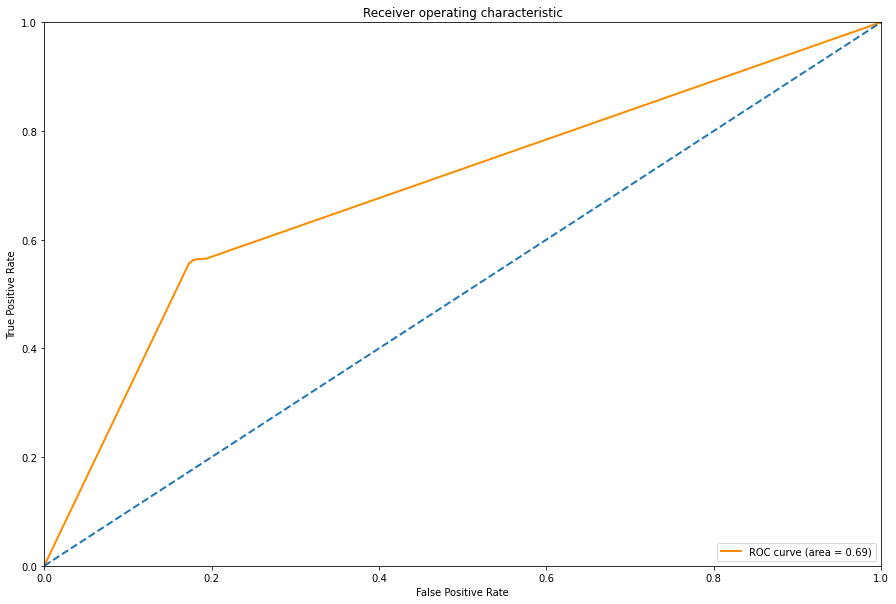

In [208]:
# ROC curve
y_pred = [x[1] for x in clf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.46')

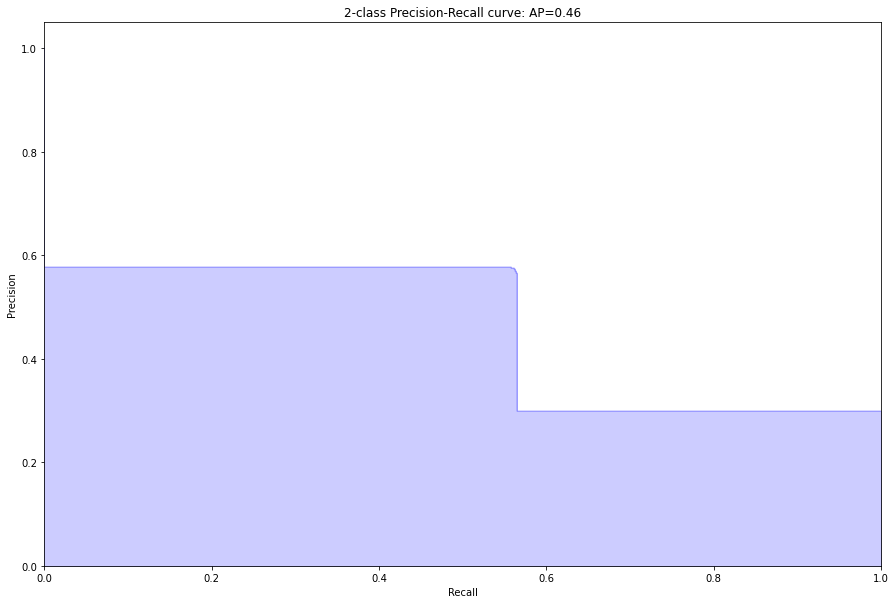

In [209]:
# PR curve
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [210]:
#Model3 Logistic Regression Classifier

In [211]:
logreg = LogisticRegression(C=1,penalty='l2')
log_pre=train_predict_evaluate_model(classifier=logreg,train_features=X_train,train_labels=y_train,test_features=X_test,test_labels=y_test)

In [212]:
accuracy_score(y_test, log_pre)

0.8060659451296249

In [213]:
pd.DataFrame(confusion_matrix(y_test, log_pre))

,0,1
0,5034,540
1,1001,1371


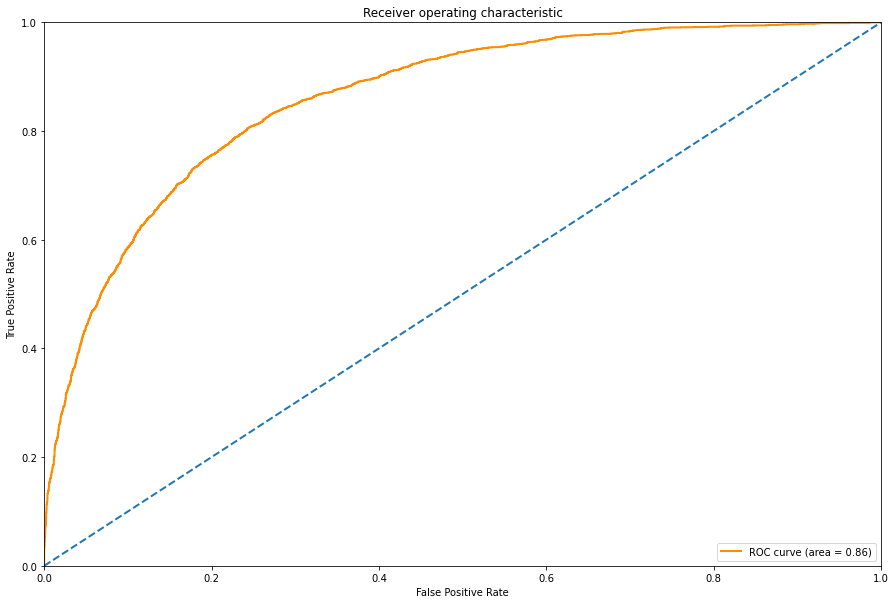

In [214]:
# ROC curve
y_pred = [x[1] for x in logreg.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.73')

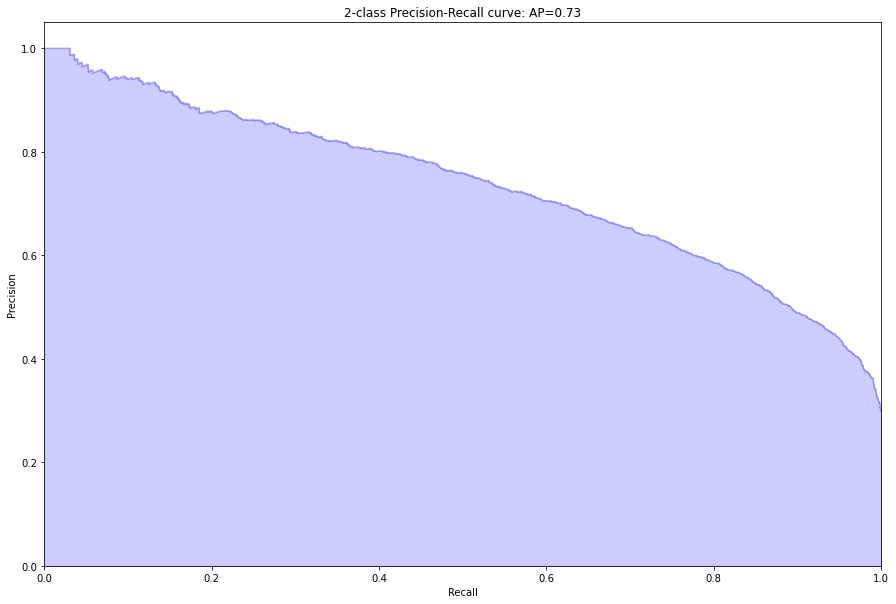

In [215]:
# PR curve
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [216]:
#Model4 KNN Classifier

In [217]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [218]:
knn_pre=train_predict_evaluate_model(classifier=knn,train_features=X_train,train_labels=y_train,test_features=X_test,test_labels=y_test)

In [219]:
accuracy_score(y_test, knn_pre)

0.7149509187012333

In [220]:
pd.DataFrame(confusion_matrix(y_test, knn_pre))

,0,1
0,4841,733
1,1532,840


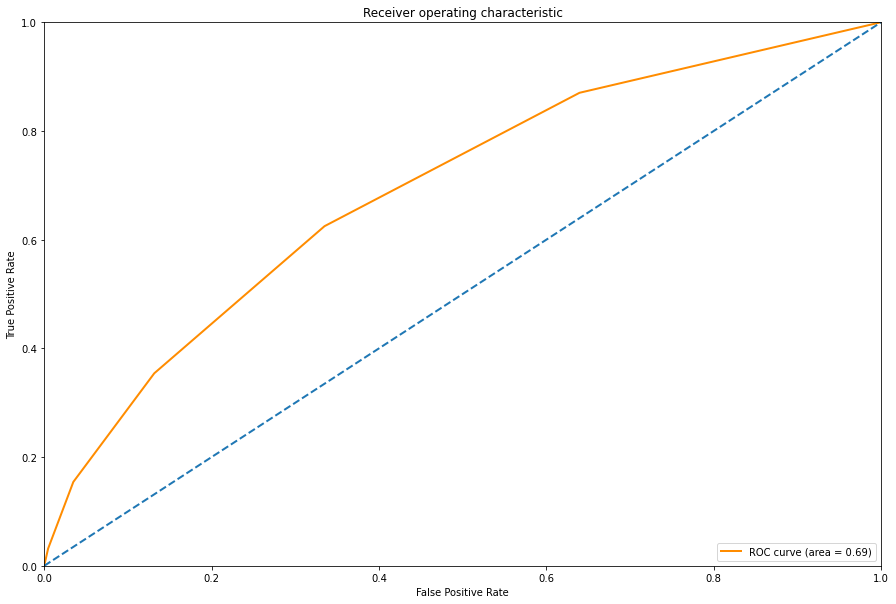

In [221]:
# ROC curve
y_pred = [x[1] for x in knn.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.46')

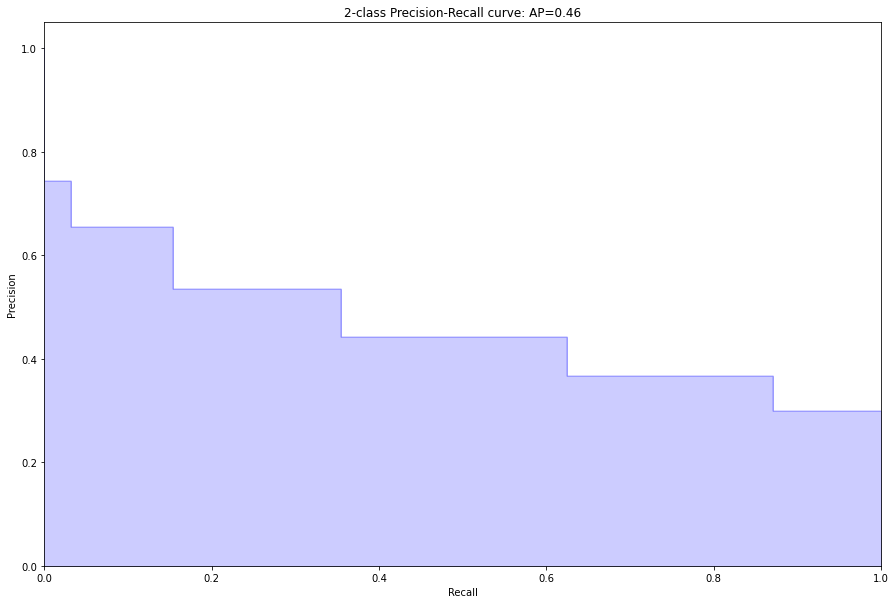

In [222]:
# PR curve
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [223]:
#Model5 Random Forest

In [224]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [225]:
rf_pre=train_predict_evaluate_model(classifier=rf,train_features=X_train,train_labels=y_train,test_features=X_test,test_labels=y_test)

In [226]:
accuracy_score(y_test, rf_pre)

0.8126101182985149

In [227]:
pd.DataFrame(confusion_matrix(y_test, rf_pre))

,0,1
0,5157,417
1,1072,1300


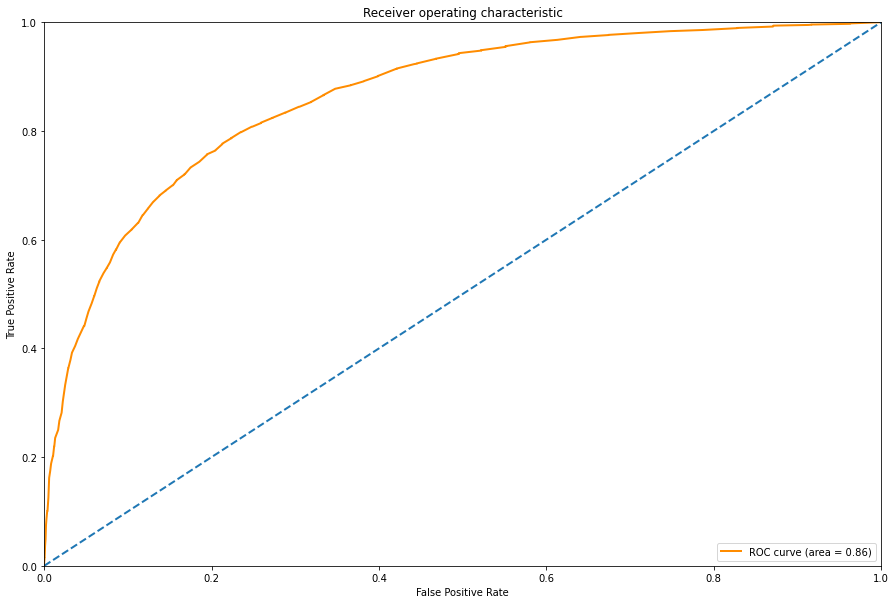

In [228]:
# ROC curve
y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.74')

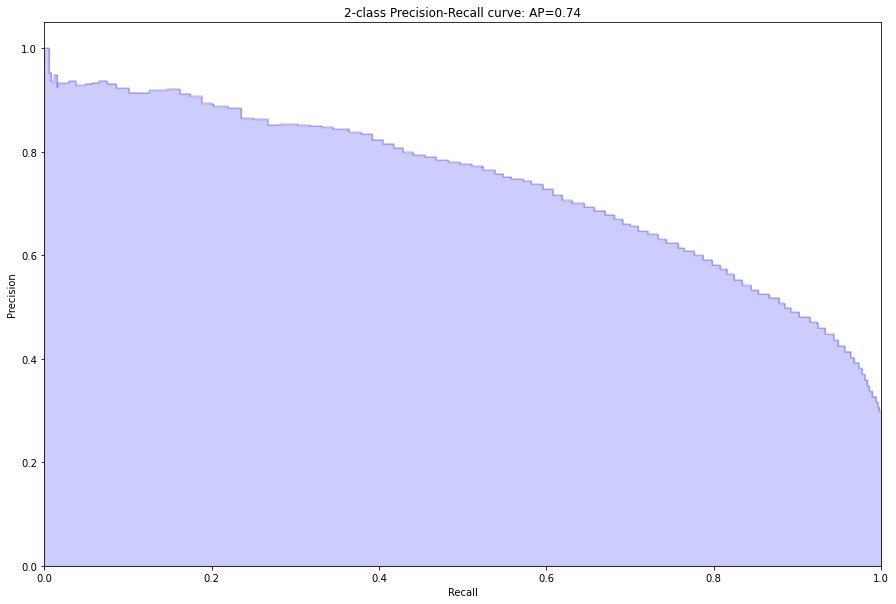

In [229]:
# PR curve
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))